# Deep Reinforcement Learning Laboratory

In this laboratory session we will work on getting more advanced versions of Deep Reinforcement Learning algorithms up and running. Deep Reinforcement Learning is **hard**, and getting agents to stably train can be frustrating and requires quite a bit of subtlety in analysis of intermediate results. We will start by refactoring (a bit) my implementation of `REINFORCE` on the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

## Exercise 1: Improving my `REINFORCE` Implementation (warm up)

In this exercise we will refactor a bit and improve some aspects of my `REINFORCE` implementation.

**First Things First**: Spend some time playing with the environment to make sure you understand how it works.

In [65]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import zipfile
import os
import sys


# Instantiate a rendering and a non-rendering environment.
env_render = gym.make('CartPole-v1', render_mode='human')
env = gym.make('CartPole-v1')

### 🔍 Esplorazione dell’ambiente CartPole

In [66]:
# Your code here. Call .reset() on the environment and inspect the output. Also, check out the observation_space.

env = gym.make("CartPole-v1")
obs, info = env.reset()

print("🔍 Osservazione iniziale:", obs)
print("📏 Spazio osservazione:", env.observation_space)
print("🎮 Spazio azioni:", env.action_space)
print("🔻 Basso:", env.observation_space.low)
print("🔺 Alto:", env.observation_space.high)

# Esegui un episodio casuale
done = False
total_reward = 0
while not done:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    done = terminated or truncated
print("🎯 Episodio terminato con reward:", total_reward)
env.close()


🔍 Osservazione iniziale: [0.0221183  0.02268248 0.01809069 0.03576595]
📏 Spazio osservazione: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
🎮 Spazio azioni: Discrete(2)
🔻 Basso: [-4.8               -inf -0.41887903        -inf]
🔺 Alto: [4.8               inf 0.41887903        inf]
🎯 Episodio terminato con reward: 44.0


**Next Things Next**: Now get your `REINFORCE` implementation working on the environment. You can import my (probably buggy and definitely inefficient) implementation here. Or even better, refactor an implementation into a separate package from which you can `import` the stuff you need here.

### 📦 Setup iniziale: carica ed estrai il pacchetto `cartpole_rl_package_updated.zip`

In [67]:
import zipfile, sys, os
from google.colab import files

uploaded = files.upload()

with zipfile.ZipFile("cartpole_rl_package_updated.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

# Cerca cartella che contiene policy.py
for root, dirs, files in os.walk("/content"):
    if "policy.py" in files:
        if root not in sys.path:
            sys.path.append(root)
        print(f"✅ Aggiunto al path: {root}")
        break



Saving cartpole_rl_package_updated.zip to cartpole_rl_package_updated (5).zip
✅ Aggiunto al path: /content/cartpole_rl


### 🧠 Import delle classi e funzioni dal pacchetto

In [68]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from cartpole_rl.policy import PolicyNet
from cartpole_rl.agent import run_episode
from cartpole_rl.utils import compute_returns, select_action

# Reproducibilità
seed = 2112
torch.manual_seed(seed)
np.random.seed(seed)

### 🔁 Training con REINFORCE originale (senza valutazione)

In [69]:

def reinforce_original(policy, env, env_render=None, gamma=0.99, num_episodes=500, lr=1e-2):
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)
    running_rewards = [0.0]
    policy.train()

    for episode in range(num_episodes):
        _, _, log_probs, rewards = run_episode(env, policy)
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)

        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        optimizer.zero_grad()
        loss = (-log_probs * returns).mean()
        loss.backward()
        optimizer.step()

        if episode % 100 == 0 and env_render:
            policy.eval()
            run_episode(env_render, policy)
            policy.train()

    return running_rewards


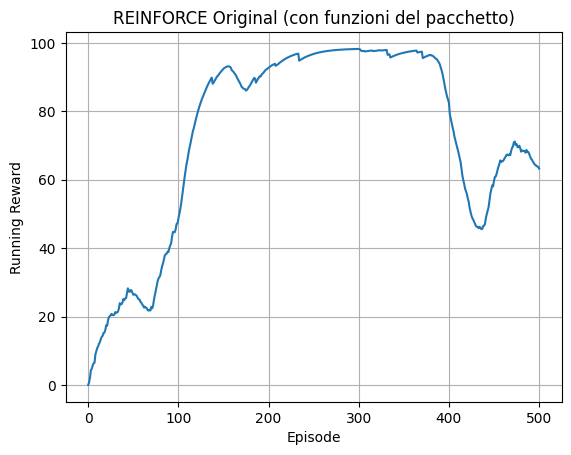

In [70]:

# 🧪 Esegui il training
env = gym.make("CartPole-v1")
env.reset(seed=seed)
policy = PolicyNet(env.observation_space.shape[0], env.action_space.n)

rewards = reinforce_original(policy, env)

# 📈 Visualizza andamento dei reward
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Running Reward")
plt.title("REINFORCE Original (con funzioni del pacchetto)")
plt.grid()
plt.show()

**Last Things Last**: My implementation does a **super crappy** job of evaluating the agent performance during training. The running average is not a very good metric. Modify my implementation so that every $N$ iterations (make $N$ an argument to the training function) the agent is run for $M$ episodes in the environment. Collect and return: (1) The average **total** reward received over the $M$ iterations; and (2) the average episode length. Analyze the performance of your agents with these new metrics.

## 🧪 Training con REINFORCE migliorato (valutazione ogni N episodi)

#prima definiamo la funzione di training

In [71]:
def reinforce_with_eval(
    policy,
    env,
    gamma=0.99,
    num_episodes=500,
    lr=1e-2,
    eval_every=50,
    eval_episodes=20
):
    import numpy as np
    import torch

    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)
    running_rewards = [0.0]
    eval_metrics = []  # list of (episode, avg_reward, avg_length)

    # Ambiente SEPARATO per la valutazione
    env_eval = gym.make("CartPole-v1")

    def evaluate_agent(policy, env_eval, num_episodes):
        policy.eval()
        total_rewards = []
        episode_lengths = []
        for _ in range(num_episodes):
            obs, _ = env_eval.reset()
            done = False
            total_reward = 0
            steps = 0
            while not done:
                obs_tensor = torch.tensor(obs, dtype=torch.float32)
                with torch.no_grad():
                    action, _ = select_action(policy, obs_tensor)
                obs, reward, terminated, truncated, _ = env_eval.step(action)
                done = terminated or truncated
                total_reward += reward
                steps += 1
            total_rewards.append(total_reward)
            episode_lengths.append(steps)
        policy.train()
        return np.mean(total_rewards), np.mean(episode_lengths)

    policy.train()
    for episode in range(num_episodes):
        _, _, log_probs, rewards = run_episode(env, policy)
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        optimizer.zero_grad()
        loss = (-log_probs * returns).mean()
        loss.backward()
        optimizer.step()

        if (episode + 1) % eval_every == 0:
            avg_reward, avg_length = evaluate_agent(policy, env_eval, eval_episodes)
            eval_metrics.append((episode + 1, avg_reward, avg_length))
            print(f"[Ep {episode + 1}] Eval → reward: {avg_reward:.2f}, length: {avg_length:.1f}")

    env_eval.close()
    return running_rewards, eval_metrics



#training con funzione migliorata

[Ep 50] Eval → reward: 135.30, length: 135.3
[Ep 100] Eval → reward: 77.30, length: 77.3
[Ep 150] Eval → reward: 106.60, length: 106.6
[Ep 200] Eval → reward: 134.80, length: 134.8
[Ep 250] Eval → reward: 78.20, length: 78.2
[Ep 300] Eval → reward: 109.00, length: 109.0
[Ep 350] Eval → reward: 200.70, length: 200.7
[Ep 400] Eval → reward: 349.80, length: 349.8
[Ep 450] Eval → reward: 500.00, length: 500.0
[Ep 500] Eval → reward: 500.00, length: 500.0


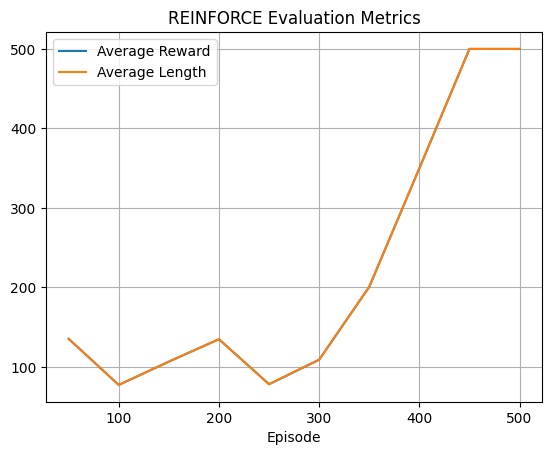

In [72]:
env = gym.make("CartPole-v1")
env_render = gym.make("CartPole-v1", render_mode="human")
policy = PolicyNet(env.observation_space.shape[0], env.action_space.n)

rewards, eval_metrics = reinforce_with_eval(
    policy,
    env,
    num_episodes=500,
    eval_every=50,
    eval_episodes=10
)

# 📈 Grafico delle metriche di valutazione
episodes = [e[0] for e in eval_metrics]
avg_rewards = [e[1] for e in eval_metrics]
avg_lengths = [e[2] for e in eval_metrics]

plt.plot(episodes, avg_rewards, label="Average Reward")
plt.plot(episodes, avg_lengths, label="Average Length")
plt.xlabel("Episode")
plt.title("REINFORCE Evaluation Metrics")
plt.legend()
plt.grid()
plt.show()

env_render.close()


In [74]:
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation

# Ambiente con rendering su array
env_display = gym.make("CartPole-v1", render_mode="rgb_array")

frames = []
obs, _ = env_display.reset()
done = False

policy.eval()
while not done:
    frame = env_display.render()
    frames.append(frame)
    obs_tensor = torch.tensor(obs, dtype=torch.float32)
    with torch.no_grad():
        action, _ = select_action(policy, obs_tensor)
    obs, reward, terminated, truncated, _ = env_display.step(action)
    done = terminated or truncated

env_display.close()



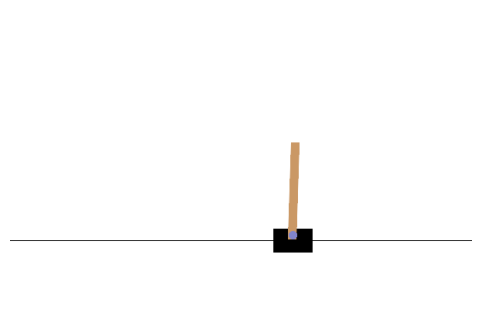

In [75]:
def display_episode(frames):
    fig = plt.figure(figsize=(6, 4))
    plt.axis('off')
    im = plt.imshow(frames[0])

    def update(frame):
        im.set_array(frame)
        return [im]

    ani = animation.FuncAnimation(
        fig, update, frames=frames, interval=50, blit=True
    )
    return HTML(ani.to_jshtml())

display_episode(frames)


-----
## Exercise 2: `REINFORCE` with a Value Baseline (warm up)

In this exercise we will augment my implementation (or your own) of `REINFORCE` to subtract a baseline from the target in the update equation in order to stabilize (and hopefully speed-up) convergence. For now we will stick to the Cartpole environment.



**First Things First**: Recall from the slides on Deep Reinforcement Learning that we can **subtract** any function that doesn't depend on the current action from the q-value without changing the (maximum of our) objecttive function $J$:  

$$ \nabla J(\boldsymbol{\theta}) \propto \sum_{s} \mu(s) \sum_a \left( q_{\pi}(s, a) - b(s) \right) \nabla \pi(a \mid s, \boldsymbol{\theta}) $$

In `REINFORCE` this means we can subtract from our target $G_t$:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - b(S_t)) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

Since we are only interested in the **maximum** of our objective, we can also **rescale** our target by any function that also doesn't depend on the action. A **simple baseline** which is even independent of the state -- that is, it is **constant** for each episode -- is to just **standardize rewards within the episode**. So, we **subtract** the average return and **divide** by the variance of returns:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha \left(\frac{G_t - \bar{G}}{\sigma_G}\right) \nabla  \pi(A_t \mid s, \boldsymbol{\theta}) $$

This baseline is **already** implemented in my implementation of `REINFORCE`. Experiment with and without this standardization baseline and compare the performance. We are going to do something more interesting.

# # a. senza baseline

In [76]:
def reinforce_without_baseline(policy, env, num_episodes=500, gamma=0.99, lr=1e-2):
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)
    policy.train()
    running_rewards = []

    for episode in range(num_episodes):
        _, _, log_probs, rewards = run_episode(env, policy)

        # Assicurati che sia un tensore float32 (e NON richieda gradiente per operazioni esterne)
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)

        # Nessuna normalizzazione
        loss = -(log_probs * returns).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_rewards.append(sum(rewards))  # ← sum è sicuro se rewards è lista di float

    return running_rewards


## b. con baseline

In [77]:
def reinforce_with_baseline(policy, env, num_episodes=500, gamma=0.99, lr=1e-2):
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)
    policy.train()
    running_rewards = []

    for episode in range(num_episodes):
        _, _, log_probs, rewards = run_episode(env, policy)

        # Assicurati che returns sia un tensore
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)

        # Baseline: standardizzazione
        baseline = returns.mean().detach()
        std = returns.std().detach() + 1e-9
        normalized_returns = (returns - baseline) / std

        loss = -(log_probs * normalized_returns).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_rewards.append(sum(rewards))

    return running_rewards




##confronto grafici

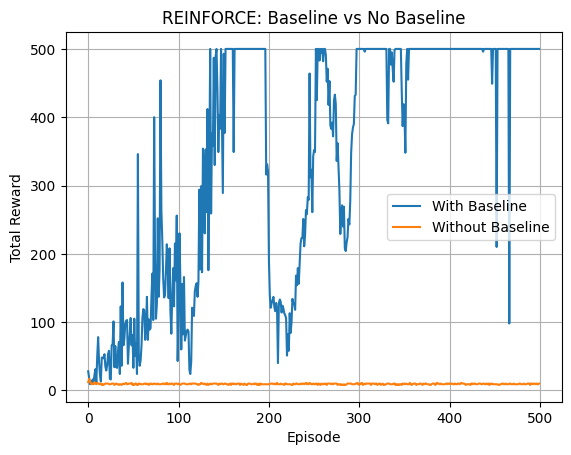

In [78]:

# Train both
env1 = gym.make("CartPole-v1")
env2 = gym.make("CartPole-v1")

policy1 = PolicyNet(env1.observation_space.shape[0], env1.action_space.n)
policy2 = PolicyNet(env2.observation_space.shape[0], env2.action_space.n)

rewards_with_baseline = reinforce_with_baseline(policy1, env1)
rewards_without_baseline = reinforce_without_baseline(policy2, env2)

# Plot
plt.plot(rewards_with_baseline, label="With Baseline")
plt.plot(rewards_without_baseline, label="Without Baseline")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("REINFORCE: Baseline vs No Baseline")
plt.legend()
plt.grid()
plt.show()


**The Real Exercise**: Standard practice is to use the state-value function $v(s)$ as a baseline. This is intuitively appealing -- we are more interested in updating out policy for returns that estimate the current **value** worse. Our new update becomes:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

where $\tilde{v}(s \mid \mathbf{w})$ is a **deep neural network** with parameters $w$ that estimates $v_\pi(s)$. What neural network? Typically, we use the **same** network architecture as that of the Policy.

**Your Task**: Modify your implementation to fit a second, baseline network to estimate the value function and use it as **baseline**.

##Definire una rete di baseline

In [79]:
import torch.nn as nn
class ValueNet(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)


##Funzione run_episode_with_logprobs

In [85]:
def run_episode_with_logprobs(env, policy):
    obs, _ = env.reset()
    done = False

    states = []
    log_probs = []
    rewards = []
    actions = []

    while not done:
        obs_tensor = torch.tensor(obs, dtype=torch.float32)
        action, log_prob = select_action(policy, obs_tensor)

        obs, reward, terminated, truncated, _ = env.step(action)

        states.append(obs_tensor)
        # Ensure log_prob is a tensor before appending
        log_probs.append(log_prob if isinstance(log_prob, torch.Tensor) else torch.tensor(log_prob, dtype=torch.float32))
        rewards.append(reward)
        actions.append(action)

        obs = obs
        done = terminated or truncated

    return states, log_probs, rewards, actions


##funzione compute returs

In [81]:
def compute_returns(rewards, gamma=0.99):
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    return returns


##Funzione di training reinforce_with_learned_baseline

In [82]:
import torch.nn.functional as F

def reinforce_with_learned_baseline(policy, value_net, env, num_episodes=500, gamma=0.99, lr=1e-2):
    policy_optimizer = torch.optim.Adam(policy.parameters(), lr=lr)
    value_optimizer = torch.optim.Adam(value_net.parameters(), lr=lr)
    policy.train()
    value_net.train()

    rewards_per_episode = []

    for episode in range(num_episodes):
        states, log_probs, rewards, _ = run_episode_with_logprobs(env, policy)

        returns = compute_returns(rewards, gamma)
        states_tensor = torch.stack(states)
        returns_tensor = torch.tensor(returns, dtype=torch.float32)
        log_probs_tensor = torch.stack(log_probs)

        # Predizioni della rete del valore
        value_preds = value_net(states_tensor).squeeze()

        # Compute advantage
        advantage = returns_tensor - value_preds.detach()

        # Policy loss
        policy_loss = (-log_probs_tensor * advantage).mean()

        # Value loss
        value_loss = F.mse_loss(value_preds, returns_tensor)

        # Ottimizzazione policy
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        # Ottimizzazione value network
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

        rewards_per_episode.append(sum(rewards))

        if episode % 50 == 0:
            print(f"[Ep {episode}] Reward: {sum(rewards)}")

    return rewards_per_episode


##Allenamento e plot

[Ep 0] Reward: 19.0
[Ep 50] Reward: 10.0
[Ep 100] Reward: 10.0
[Ep 150] Reward: 13.0
[Ep 200] Reward: 58.0
[Ep 250] Reward: 64.0
[Ep 300] Reward: 156.0
[Ep 350] Reward: 500.0
[Ep 400] Reward: 500.0
[Ep 450] Reward: 500.0


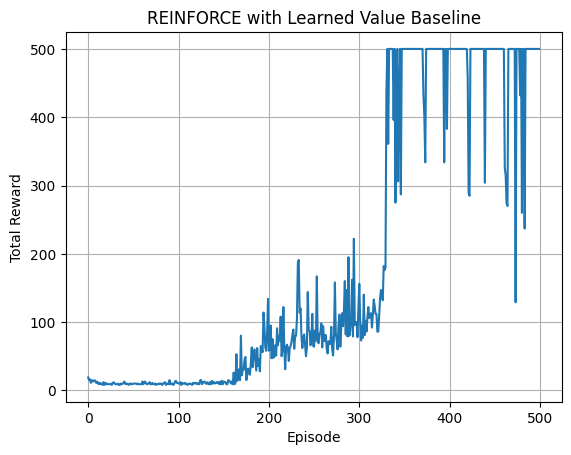

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import gymnasium as gym

env = gym.make("CartPole-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n

policy = PolicyNet(obs_dim, act_dim)
value_net = ValueNet(obs_dim)

rewards = reinforce_with_learned_baseline(policy, value_net, env)

plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("REINFORCE with Learned Value Baseline")
plt.grid()
plt.show()

env.close()


-----
## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.



In [94]:
import gymnasium as gym
import torch
import numpy as np
import matplotlib.pyplot as plt
from cartpole_rl.policy import PolicyNet
from cartpole_rl.value import ValueNet
from cartpole_rl.utils import select_action  # Assicurati che questa funzioni nel nuovo env

##funzione di training

In [95]:
import torch.nn.functional as F

def reinforce_lunarlander_with_value_baseline(policy, value_net, env, num_episodes=1000, gamma=0.99, lr=1e-3):
    policy_optimizer = torch.optim.Adam(policy.parameters(), lr=lr)
    value_optimizer = torch.optim.Adam(value_net.parameters(), lr=lr)

    rewards_per_episode = []

    for episode in range(num_episodes):
        states, log_probs, rewards, _ = run_episode_with_logprobs(env, policy)

        returns = compute_returns(rewards, gamma)
        states_tensor = torch.stack(states)
        returns_tensor = torch.tensor(returns, dtype=torch.float32)

        # log_probs already checked to be tensors with grad
        log_probs_tensor = torch.stack(log_probs)

        value_preds = value_net(states_tensor).squeeze()
        advantage = returns_tensor - value_preds.detach()

        # Policy loss
        policy_loss = (-log_probs_tensor * advantage).mean()

        # Value loss
        value_loss = F.mse_loss(value_preds, returns_tensor)

        # Optimize policy
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        # Optimize value network
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

        total_reward = sum(rewards)
        rewards_per_episode.append(total_reward)

        if episode % 50 == 0:
            print(f"[Ep {episode}] Reward: {total_reward:.2f}")

    return rewards_per_episode


In [89]:
# ✅ Installa SWIG (necessario per Box2D)
!pip install swig

# ✅ Installa Gymnasium con supporto Box2D (per LunarLander)
!pip install "gymnasium[box2d]"


##allenammento su luna_lander

In [9]:
env = gym.make("LunarLander-v3")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n

policy = PolicyNet(obs_dim, act_dim)
value_net = ValueNet(obs_dim)

rewards = reinforce_lunarlander_with_value_baseline(policy, value_net, env, num_episodes=5000)
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("REINFORCE on LunarLander with Value Baseline")
plt.grid()
plt.show()


NameError: name 'PolicyNet' is not defined

##salva e visualizza agente

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import matplotlib.animation as animation

# Crea ambiente con rendering per ottenere immagini
env_vis = gym.make("LunarLander-v3", render_mode="rgb_array")
obs, _ = env_vis.reset()
done = False
frames = []

while not done:
    obs_tensor = torch.tensor(obs, dtype=torch.float32)
    with torch.no_grad():
        action, _ = select_action(policy, obs_tensor)
    obs, reward, terminated, truncated, _ = env_vis.step(action)
    frames.append(env_vis.render())
    done = terminated or truncated

env_vis.close()

# Funzione di utilità per visualizzare i frame come animazione
def display_episode(frames):
    fig = plt.figure()
    plt.axis("off")
    im = plt.imshow(frames[0])

    def update(i):
        im.set_array(frames[i])
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=40)
    plt.close(fig)
    return HTML(ani.to_jshtml())

# Mostra l'episodio
display(display_episode(frames))


### Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.




In [ ]:
!pip install numpy==1.23.5 --quiet
import os
os.kill(os.getpid(), 9)  # Forza il riavvio del runtime Colab


##Q-network

In [1]:
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)


##Replay Buffer

In [2]:
import random
import numpy as np
from collections import deque
import torch

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size=64):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)


##funzione di addestramento

In [3]:
import torch
import torch.optim as optim
import gym
import numpy as np

def train_dqn(env_name="CartPole-v1", episodes=500, gamma=0.99, lr=1e-3, batch_size=64,
              buffer_capacity=10000, min_buffer_size=1000, epsilon_start=1.0,
              epsilon_end=0.01, epsilon_decay=0.995, target_update_freq=10):

    env = gym.make(env_name)
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    q_net = QNetwork(obs_dim, n_actions)
    target_net = QNetwork(obs_dim, n_actions)
    target_net.load_state_dict(q_net.state_dict())  # inizializza target con q_net

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    buffer = ReplayBuffer(capacity=buffer_capacity)

    epsilon = epsilon_start
    rewards = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            # ε-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(np.array(state), dtype=torch.float32).unsqueeze(0)
                    q_values = q_net(state_tensor)
                    action = torch.argmax(q_values).item()

            next_state, reward, done, _ = env.step(action)
            buffer.add(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

            # Train only if we have enough data
            if len(buffer) >= min_buffer_size:
                states, actions, rewards_b, next_states, dones = buffer.sample(batch_size)

                # Compute target Q values
                with torch.no_grad():
                    target_q = target_net(next_states).max(1)[0]
                    targets = rewards_b + gamma * target_q * (1 - dones)

                # Compute current Q estimates
                q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze()

                # Loss and update
                loss = torch.nn.functional.mse_loss(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Update epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        rewards.append(total_reward)

        # Update target network
        if episode % target_update_freq == 0:
            target_net.load_state_dict(q_net.state_dict())

        if episode % 10 == 0:
            print(f"[Episode {episode}] Reward: {total_reward:.1f}, Epsilon: {epsilon:.3f}")

    env.close()
    return rewards


##allenamento cartpole

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


[Episode 0] Reward: 13.0, Epsilon: 0.995
[Episode 10] Reward: 22.0, Epsilon: 0.946
[Episode 20] Reward: 30.0, Epsilon: 0.900
[Episode 30] Reward: 14.0, Epsilon: 0.856
[Episode 40] Reward: 13.0, Epsilon: 0.814
[Episode 50] Reward: 36.0, Epsilon: 0.774
[Episode 60] Reward: 40.0, Epsilon: 0.737
[Episode 70] Reward: 15.0, Epsilon: 0.701
[Episode 80] Reward: 41.0, Epsilon: 0.666
[Episode 90] Reward: 27.0, Epsilon: 0.634
[Episode 100] Reward: 22.0, Epsilon: 0.603
[Episode 110] Reward: 66.0, Epsilon: 0.573
[Episode 120] Reward: 155.0, Epsilon: 0.545
[Episode 130] Reward: 26.0, Epsilon: 0.519
[Episode 140] Reward: 16.0, Epsilon: 0.493
[Episode 150] Reward: 21.0, Epsilon: 0.469
[Episode 160] Reward: 67.0, Epsilon: 0.446
[Episode 170] Reward: 127.0, Epsilon: 0.424
[Episode 180] Reward: 61.0, Epsilon: 0.404
[Episode 190] Reward: 150.0, Epsilon: 0.384
[Episode 200] Reward: 122.0, Epsilon: 0.365
[Episode 210] Reward: 107.0, Epsilon: 0.347
[Episode 220] Reward: 106.0, Epsilon: 0.330
[Episode 230] Re

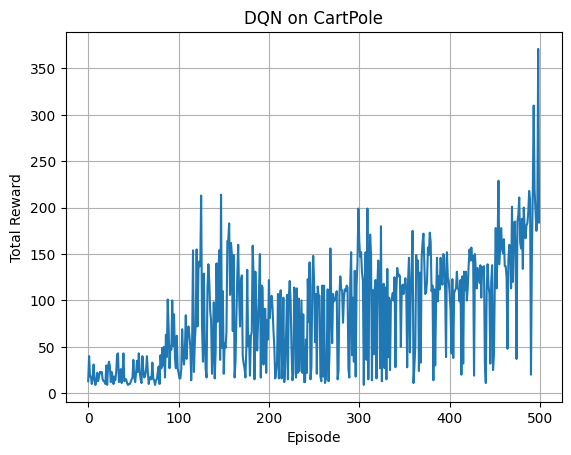

In [4]:
import matplotlib.pyplot as plt

rewards = train_dqn("CartPole-v1", episodes=500)
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN on CartPole")
plt.grid()
plt.show()

#allenamento lunarlander

<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


[Episode 0] Reward: -206.1, Epsilon: 0.995
[Episode 10] Reward: -120.7, Epsilon: 0.946
[Episode 20] Reward: -139.0, Epsilon: 0.900
[Episode 30] Reward: -237.6, Epsilon: 0.856
[Episode 40] Reward: -167.1, Epsilon: 0.814
[Episode 50] Reward: -108.5, Epsilon: 0.774
[Episode 60] Reward: -317.7, Epsilon: 0.737
[Episode 70] Reward: -52.8, Epsilon: 0.701
[Episode 80] Reward: -54.5, Epsilon: 0.666
[Episode 90] Reward: -44.2, Epsilon: 0.634
[Episode 100] Reward: 1.1, Epsilon: 0.603
[Episode 110] Reward: -9.0, Epsilon: 0.573
[Episode 120] Reward: -98.8, Epsilon: 0.545
[Episode 130] Reward: -21.2, Epsilon: 0.519
[Episode 140] Reward: -23.4, Epsilon: 0.493
[Episode 150] Reward: 3.8, Epsilon: 0.469
[Episode 160] Reward: 22.4, Epsilon: 0.446
[Episode 170] Reward: -12.5, Epsilon: 0.424
[Episode 180] Reward: -25.4, Epsilon: 0.404
[Episode 190] Reward: 31.1, Epsilon: 0.384
[Episode 200] Reward: -80.3, Epsilon: 0.365
[Episode 210] Reward: -11.5, Epsilon: 0.347
[Episode 220] Reward: -339.3, Epsilon: 0.33

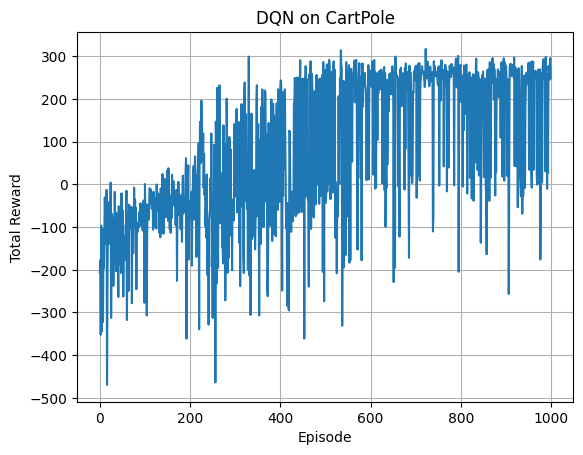

In [6]:
import matplotlib.pyplot as plt

rewards = train_dqn("LunarLander-v2", episodes=1000)
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN on CartPole")
plt.grid()
plt.show()


### Exercise 3.3: Solving the OpenAI CarRacing environment (hardest)

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.
